In [24]:
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
from expecto import get_spectrum

In [2]:
with open("data/bhac15_tracks.txt",'r') as hdl:
    raw = hdl.readlines()

In [3]:
# skip header 
lines = raw[43:]
nlines = len(lines)

# mass tracks 
tracks = []

# loop through file
i = 0
arr_keys = ["arr_age",          
            "arr_Teff",      
            "arr_L/Ls",       
            "arr_logg",      
            "arr_R/Rs",     
            "arr_logli",
            "arr_tcentral", 
            "arr_rhocentral", 
            "arr_mcore", 
            "arr_rcore", 
            "arr_k2c", 
            "arr_k2r"
            ]
track = {}
while i < nlines:

    l = lines[i][1:-1].strip()
    if len(l) == 0:
        i += 1
        continue 

    if "----------" in l:
        # skip header
        i += 3
        tracks.append(track)
        track = {"mass":0.0}
        for k in arr_keys:
            track[k] = []
        continue

    # read data
    lsplit = l.split(" ")
    values = []
    for l in lsplit:
        l = l.replace(' ','')
        if len(l) > 0:
            values.append(float(l))
    track["mass"] = values[0]
    for j,key in enumerate(arr_keys):
        track[key].append(values[j+1])

    i += 1

# Drop dummy value
tracks = tracks[1:]

# Rescale units
for t in tracks:
    for k in arr_keys:
        t[k] = np.array(t[k], dtype=float)

    # Convert logt to years
    t["arr_age"] = 10.0 ** t["arr_age"]

In [39]:
def best_track(mass):
    m_val, m_idx = 9e99, -1
    for i,t in enumerate(tracks):
        m = t["mass"]
        if abs(m-mass) < abs(m_val - mass):
            m_val = m
            m_idx = i
    return tracks[m_idx]

def track_interp(track:dict, age:float, key:str):
    track_age = track["arr_age"]
    age = max(age, np.amin(track_age))
    age = min(age, np.amax(track_age))

    itp = PchipInterpolator(track_age, track[key])

    return itp(age)


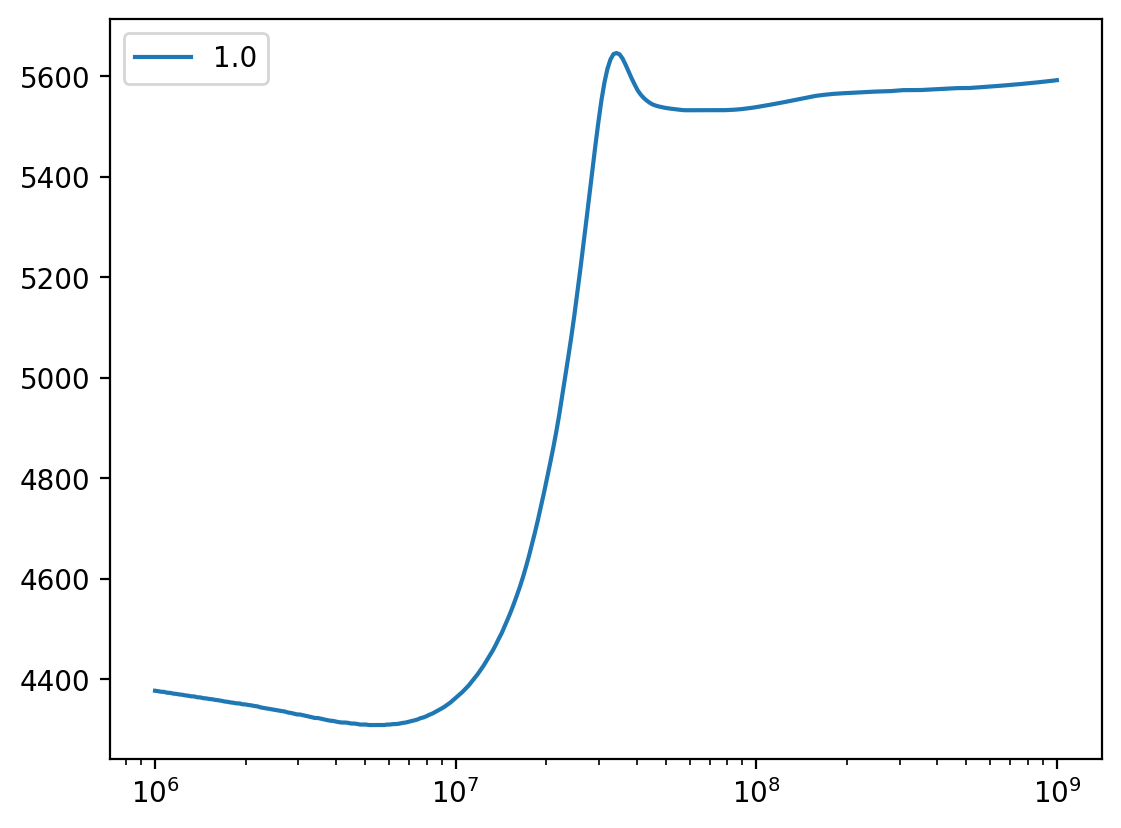

In [40]:
plt.close("all")
fig,ax = plt.subplots(1,1)

for m in [1.0]:
    track = best_track(m)

    x = np.logspace(6,9,300)
    y = [track_interp(track, t, "arr_Teff") for t in x]
    ax.plot(x,y , label=track["mass"])

ax.set_xscale("log")
ax.legend()
plt.show()
    

In [49]:


track = best_track(1.0)

arr_age  = np.logspace(5,8,5)
arr_teff = []
arr_logg = [track_interp(track, t, "arr_logg") for t in arr_age]

specs_wl = []
specs_fl = []

for i,t in enumerate(arr_age):
    print(t)
    teff = track_interp(track, t, "arr_Teff")
    logg = track_interp(track, t, "arr_logg") 

    spectrum = get_spectrum(T_eff=teff, log_g=logg, cache=True)

    specs_wl.append(np.array(spectrum.wavelength))
    specs_fl.append(np.array(spectrum.flux))



100000.0
562341.3251903491
3162277.6601683795
17782794.100389227
100000000.0


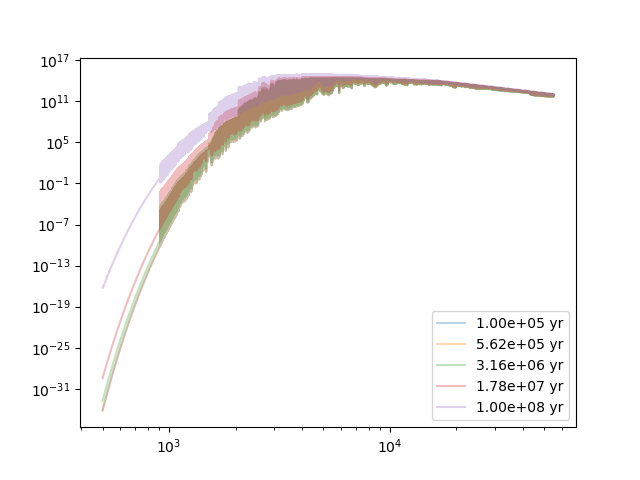

In [50]:
%matplotlib widget

plt.close("all")
fig,ax = plt.subplots(1,1)

for i,t in enumerate(arr_age):
    ax.plot(specs_wl[i],specs_fl[i], label="%.2e yr"%t, alpha=0.3)

ax.set_xscale("log")
ax.set_yscale("log")
ax.legend(loc='lower right')
plt.show()